In [438]:
import os
os.getcwd()

'C:\\Users\\dzfal'

In [439]:
import pandas as pd
import numpy as np

In [440]:
data = pd.read_excel(r'OneDrive\Desktop\CPI_IJC_2012_2022.xlsx')
data

,Year,Month,CPI,IJC
0,2012,JAN,227.842,372000
1,2012,FEB,228.329,365000
2,2012,MAR,228.807,358000
3,2012,APR,229.187,372000
4,2012,MAY,228.713,381000
...,...,...,...,...
124,2022,MAY,291.474,202000
125,2022,JUN,295.328,231000
126,2022,JUL,295.271,248000
127,2022,AUG,295.620,228000


In [441]:
data.loc[data['Year'] < 2020, 'Period'] = 1
data.loc[data['Year'] == 2020, 'Period'] = 2
data.loc[data['Year'] > 2020, 'Period'] = 3
data['Period'] = data['Period'].astype(int)

In [442]:
data

,Year,Month,CPI,IJC,Period
0,2012,JAN,227.842,372000,1
1,2012,FEB,228.329,365000,1
2,2012,MAR,228.807,358000,1
3,2012,APR,229.187,372000,1
4,2012,MAY,228.713,381000,1
...,...,...,...,...,...
124,2022,MAY,291.474,202000,3
125,2022,JUN,295.328,231000,3
126,2022,JUL,295.271,248000,3
127,2022,AUG,295.620,228000,3


## Question 1

In [443]:
col = ["CPI", "IJC"]
data_cp = data[col]

In [444]:
data_cp

,CPI,IJC
0,227.842,372000
1,228.329,365000
2,228.807,358000
3,229.187,372000
4,228.713,381000
...,...,...
124,291.474,202000
125,295.328,231000
126,295.271,248000
127,295.620,228000


In [445]:
data_cp= np.log(data_cp)
data_cp["Period"] = data["Period"]
data_cp

,CPI,IJC,Period
0,5.428652,12.826649,1
1,5.430788,12.807653,1
2,5.432879,12.788288,1
3,5.434538,12.826649,1
4,5.432468,12.850555,1
...,...,...,...
124,5.674951,12.216023,3
125,5.688087,12.350173,3
126,5.687894,12.421184,3
127,5.689075,12.337101,3


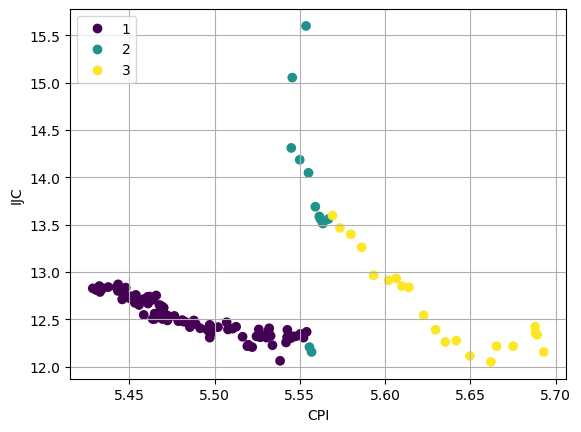

In [446]:
import matplotlib.pyplot as plt

u, inv = np.unique(data_cp.Period.values, return_inverse=True)

scatter = plt.scatter(data_cp["CPI"], data_cp["IJC"], c=inv)
plt.legend(scatter.legend_elements()[0], u, loc=2)
plt.xlabel("CPI")
plt.ylabel("IJC")
plt.grid()
plt.show()

## Question 2

In [447]:
def SWEEPOperator (pDim, inputM, origDiag, sweepCol = None, tol = 1e-7):
    ''' Implement the SWEEP operator
    Parameter
    ---------
    pDim: dimension of matrix inputM, integer greater than one
    inputM: a square and symmetric matrix, np array
    origDiag: the original diagonal elements before any SWEEPing
    sweepCol: a list of columns numbers to SWEEP
    tol: singularity tolerance, positive real
    Return
    ------
    A: negative of a generalized inverse of input matrix
    aliasParam: a list of aliased rows/columns in input matrix
    nonAliasParam: a list of non-aliased rows/columns in input matrix
    '''
    if (sweepCol is None):
        sweepCol = range(pDim)
    aliasParam = []
    nonAliasParam = []
    A = np.copy(inputM)
    ANext = np.zeros((pDim,pDim))
    for k in sweepCol:
        Akk = A[k,k]
        pivot = tol * abs(origDiag[k])
        if (not np.isinf(Akk) and abs(Akk) >= pivot and pivot > 0.0):
            nonAliasParam.append(k)
            ANext = A - np.outer(A[:, k], A[k, :]) / Akk
            ANext[:, k] = A[:, k] / abs(Akk)
            ANext[k, :] = ANext[:, k]
            ANext[k, k] = -1.0 / Akk
        else:
            aliasParam.append(k)
            ANext[:,k] = np.zeros(pDim)
            ANext[k, :] = np.zeros(pDim)
        A = ANext
    return (A, aliasParam, nonAliasParam)

def LinearRegression (X, y):
    ''' Train a linear regression model
    Parameter
    ---------
    X: A pd DataFrame, rows are observations, columns are regressors
    y: A pd Series, rows are observations of the response variable
    Return
    ------
    A list of the following entities:
    1. b: an array of regression coefficient
    2. residual_SS: residual sum of squares
    3. XtX_Ginv: a generalized inverse of the XtX matrix
    4. aliasParam: a list of aliased rows/columns in input matrix
    5. nonAliasParam: a list of non-aliased rows/columns in input matrix
    '''
    # X: A pd DataFrame, rows are observations, columns are regressors
    # y: A pd Series, rows are observations of the response variable
    Z = X.join(y)
    n_sample = Z.shape[0]
    n_param = Z.shape[1] - 1
    ZtZ = Z.transpose().dot(Z)
    diag_ZtZ = np.diagonal(ZtZ)
    eps_double = np.finfo(np.float64).eps
    tol = np.sqrt(eps_double)
    ZtZ_transf, aliasParam, nonAliasParam = SWEEPOperator ((n_param+1), ZtZ, diag_ZtZ, sweepCol = range(n_param), tol = tol)
    b = ZtZ_transf[0:n_param, n_param]
    b[aliasParam] = 0.0
    XtX_Ginv = - ZtZ_transf[0:n_param, 0:n_param]
    XtX_Ginv[:, aliasParam] = 0.0
    XtX_Ginv[aliasParam, :] = 0.0
    residual_SS = ZtZ_transf[n_param, n_param]
    return ([b, residual_SS, XtX_Ginv, aliasParam, nonAliasParam])

In [448]:
X = pd.get_dummies(data_cp[['Period']].astype('category'))
X = X.iloc[:,[2,1,0]]
X = X.join(data_cp[['CPI']])
X.insert(0, 'Intercept', 1)
y = data_cp['IJC']
result_list = LinearRegression(X, y)
# Label the output properly
parameter_name = X.columns
estimate = pd.Series(result_list[0], index = parameter_name)
residual_SS = result_list[1]
cov_matrix = pd.DataFrame(result_list[2], index = parameter_name, columns = parameter_name)

In [449]:
residual_SS

12.81199636652066

In [450]:
estimate

Intercept    47.376556
Period_3      1.055882
Period_2      1.717105
Period_1      0.000000
CPI          -6.354338
dtype: float64

In [451]:
cov_matrix

,Intercept,Period_3,Period_2,Period_1,CPI
Intercept,198.012847,5.325266,2.586715,0.0,-36.103852
Period_3,5.325266,0.201819,0.080403,0.0,-0.972911
Period_2,2.586715,0.080403,0.127816,0.0,-0.473562
Period_1,0.000000,0.000000,0.000000,0.0,0.000000
CPI,-36.103852,-0.972911,-0.473562,0.0,6.583193


**Standard error should be the squareroot of the variance of the coefficients, which locate in the diagonal of the covariance matrix**

In [452]:
import math
for i in cov_matrix.index:
    standardError = math.sqrt(cov_matrix[i][i])
    print("The standard error of the coefficient of ", i, " is: ", standardError)

The standard error of the coefficient of  Intercept  is:  14.071703783412302
The standard error of the coefficient of  Period_3  is:  0.4492431158419582
The standard error of the coefficient of  Period_2  is:  0.3575132227254053
The standard error of the coefficient of  Period_1  is:  0.0
The standard error of the coefficient of  CPI  is:  2.565773295093052


## Question 3

**Use the definition**

In [453]:
def tss(a):
    m = a.mean()
    n = 0
    for i in a:
        n += ((i-m)**2)
    return (n)

In [454]:
1 - (residual_SS/tss(y))

0.6430150381336952

**Use the sklearn package**

In [455]:
from sklearn.linear_model import LinearRegression
#initiate linear regression model
model = LinearRegression()
#fit regression model
model.fit(X, y)
#calculate R-squared of regression model
r_squared = model.score(X, y)
r_squared

0.6430150381274364

**The answer of these two methods agrees with each other**

## Question 4

In [456]:
from scipy.stats import f

In [457]:
summ_stat = data_cp.groupby(by = 'Period')['IJC'].describe()
summ_stat

,count,mean,std,min,25%,50%,75%,max
Period,,,,,,,,
1,96.0,12.527799,0.191160,12.061047,12.385250,12.502467,12.707604,12.868761
2,12.0,13.787805,0.989758,12.154779,13.546112,13.637455,14.215633,15.598229
3,21.0,12.644592,0.484669,12.049419,12.259613,12.421184,12.933621,13.596110


**We can get the ANOVA table**

In [458]:
# Calculate the Within Group Sum of Squares
n_sample = data_cp.shape[0]
dfW = 0.0
SSW = 0.0
for Period in [1, 2, 3]:
   group_stat = summ_stat.loc[Period]
   group_count = group_stat['count']
   group_mean = group_stat['mean']
   group_std = group_stat['std']
   dfW = dfW + (group_count - 1)
   SSW = SSW + group_std * group_std * (group_count - 1)
   
MSW = SSW / dfW
# Calculate the Corrected Total Sum of Squares
overall_std = np.std(data_cp['IJC'], ddof = 1)
dfT = n_sample - 1
SST = overall_std * overall_std * dfT
SSB = SST - SSW
dfB = dfT - dfW
MSB = SSB / dfB
F_stat = MSB / MSW
F_sig = f.sf(F_stat, dfB, dfW)
print('\nSource: Between Group')
print('DF = ', dfB)
print('SS = ', SSB)
print('MS = ', MSB)
print('\nSource: Within Group')
print('DF = ', dfW)
print('SS = ', SSW)
print('MS = ', MSW)
print('\nSource: Total')
print('DF = ', dfT)
print('SS = ', SST)
print('F Statistic = ', F_stat)
print('     F Sig. = ', F_sig)
print('R-Square = ', (SSB/SST))


Source: Between Group
DF =  2.0
SS =  16.94402133029339
MS =  8.472010665146694

Source: Within Group
DF =  126.0
SS =  18.945435467942588
MS =  0.1503605989519253

Source: Total
DF =  128
SS =  35.889456798235976
F Statistic =  56.34461903051773
     F Sig. =  3.310362399319542e-18
R-Square =  0.472116962526059


**Since the F Significance value is very small, we will reject the null hypothesis. We can conclude that the population means of IJC are different among the three periods and thus $r_{i}$ is not equal to 0 for some $r_{i}$**

## Question 5

**In this question, the residual of original data has been given in question 2, and I ran the regression again with the input variable dropped log(CPI). Then I calculated the residual of my second regression and ran the F-test to test if the residuals of these two regression are equal, because if log(CPI) does not affect the log(IJC), the residuals which can be regarded as variance should be the same.**

In [461]:
X_b = X.drop(columns=["CPI"])
X_b

,Intercept,Period_3,Period_2,Period_1
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
124,1,1,0,0
125,1,1,0,0
126,1,1,0,0
127,1,1,0,0


In [464]:
y

0      12.826649
1      12.807653
2      12.788288
3      12.826649
4      12.850555
         ...    
124    12.216023
125    12.350173
126    12.421184
127    12.337101
128    12.154779
Name: IJC, Length: 129, dtype: float64

In [470]:
model = LinearRegression()
  
# fitting the data
model.fit(X_b, y)
  
# predicting values
y_pred = model.predict(X_b)
df = pd.DataFrame({'Actual': y, 'Predicted': y_pred})

residual = np.sum(np.square(df['Predicted'] - df['Actual']))

print(' residual sum of squares is : '+ str(np.sum(np.square(df['Predicted'] - df['Actual']))))

 residual sum of squares is : 18.945435467942588


In [473]:
import scipy.stats
scipy.stats.f.ppf(q=1-0.05, dfn=len(y_pred)-1, dfd=len(y_pred)-1)

1.337380547457587

In [475]:
F_stats = residual/residual_SS
F_stats

1.4787262598239075

In [477]:
p = 1-scipy.stats.f.cdf(F_stats, len(y_pred)-1, len(y_pred)-1)
p

0.01384786482912781

In [478]:
print("The F-test statistic is: ", F_stats, "with degrees of freedom ", "(", len(y_pred)-1, ", ", len(y_pred)-1, ")", ", and the significance level is: ", p)

The F-test statistic is:  1.4787262598239075 with degrees of freedom  ( 128 ,  128 ) , and the significance level is:  0.01384786482912781


**We can reject the null hypothesis and conclude that CPI does affect the IJC**

## Question 6

In [498]:
X.loc[len(X.index)] = [1, 1, 0, 0, math.log(298.062)] 
X

,Intercept,Period_3,Period_2,Period_1,CPI
0,1.0,0.0,0.0,1.0,5.428652
1,1.0,0.0,0.0,1.0,5.430788
2,1.0,0.0,0.0,1.0,5.432879
3,1.0,0.0,0.0,1.0,5.434538
4,1.0,0.0,0.0,1.0,5.432468
...,...,...,...,...,...
125,1.0,1.0,0.0,0.0,5.688087
126,1.0,1.0,0.0,0.0,5.687894
127,1.0,1.0,0.0,0.0,5.689075
128,1.0,1.0,0.0,0.0,5.692927


In [499]:
df_yhat = X.dot(estimate)
df_yhat

0      12.881064
1      12.867496
2      12.854208
3      12.843663
4      12.856819
         ...    
125    12.288414
126    12.289640
127    12.282134
128    12.257655
129    12.229859
Length: 130, dtype: float64

In [574]:
yhat_new = df_yhat[len(df_yhat) - 1].astype(float)
yhat_new

12.229858891340308

In [575]:
pred_origin = pow(math.e, yhat_new)
pred_origin
print("The predicted IJC of Oct 2022 is:", pred_origin)

The predicted IJC of Oct 2022 is: 204814.2789884431


**𝑁_𝑛 (𝐗𝐛,𝜎^2 𝐗(𝐗^𝑡 𝐗)^(−1) 𝐗^𝑡 )**

In [576]:
aa = X[-1:]
aa

,Intercept,Period_3,Period_2,Period_1,CPI
129,1.0,1.0,0.0,0.0,5.697302


In [577]:
a = np.linalg.inv(X.T.dot(X))
b = aa.dot(a)
proj = b.dot(aa.T.to_numpy()).values
proj = proj[0][0].astype(float)
proj

0.06207747940416741

**We can use the residual_SS in question 2 as 𝜎^2**

In [590]:
from scipy.stats import t
dof = len(y) - 5
t_critical = t.ppf(0.975, df = dof)
t_critical

1.9792801165796825

In [594]:
rss = residual_SS.astype(float)
c = t_critical * math.sqrt(rss/dof * proj)
ci_lower = yhat_new - c
ci_upper = yhat_new + c
ori_ci_lower = pow(math.e, ci_lower)
ori_ci_upper = pow(math.e, ci_upper)
print("The confidence interval of original mean prediction is: (", ori_ci_lower, ", ", ori_ci_upper, ")")

The confidence interval of original mean prediction is: ( 174790.49175115686 ,  239995.25636255418 )


## Question 7

In [365]:
y_IJC

array([ 372000,  365000,  358000,  372000,  381000,  372000,  372000,
        377000,  376000,  364000,  388000,  362000,  366000,  342000,
        375000,  331000,  353000,  340000,  334000,  325000,  319000,
        347000,  312000,  332000,  340000,  341000,  330000,  345000,
        312000,  308000,  303000,  303000,  290000,  291000,  291000,
        285000,  281000,  317000,  269000,  269000,  275000,  275000,
        269000,  279000,  272000,  275000,  265000,  276000,  282000,
        269000,  271000,  278000,  263000,  262000,  266000,  261000,
        247000,  265000,  255000,  244000,  241000,  221000,  236000,
        232000,  253000,  247000,  245000,  247000,  260000,  241000,
        243000,  248000,  223000,  202000,  205000,  200000,  224000,
        241000,  222000,  225000,  221000,  225000,  244000,  237000,
        227000,  204000,  173000,  210000,  222000,  240000,  220000,
        224000,  224000,  230000,  221000,  235000,  200000,  190000,
       5946000, 3446

In [366]:
observed_bar = y_IJC.mean()
observed_bar

406193.7984496124

In [367]:
X = X[:-1]

In [371]:
pred_IJC = pow(math.e, X.dot(estimate))
pred_IJC = pred_IJC.to_numpy()
pred_IJC

array([ 392803.19623504,  387509.80560336,  382394.36294749,
        378383.40594285,  383394.12505474,  385413.45567116,
        384706.89704234,  370803.71470123,  359756.24764153,
        353652.01924892,  357449.29716474,  357724.43879815,
        353254.51856143,  341305.70164833,  347467.66644108,
        352113.37473585,  351188.13320874,  345922.28088634,
        341650.3933297 ,  336512.87137663,  335707.96037124,
        334568.4483002 ,  330673.59600361,  325171.26218601,
        320206.66515629,  317975.94764172,  313880.72743346,
        310187.95711201,  306463.16713688,  303902.88577257,
        301738.42611002,  302045.38493709,  301908.016597  ,
        302287.97616134,  305929.43191039,  311994.4515188 ,
        324924.88427579,  319740.08289549,  314320.49853196,
        312246.31532028,  305781.81857528,  300457.9554452 ,
        297446.92433765,  297454.86483137,  301738.42611002,
        299848.12871163,  297581.94610231,  299623.81689977,
        300498.12592414,

In [372]:
rel_error = sum(np.square(y_IJC - pred_IJC)) / sum(np.square(y_IJC - observed_bar))

In [374]:
print("The relative error is: ", rel_error)

The relative error is:  0.6997043214964035
